                      Model     Test MSE   Test MAE
0             Random Forest  1058.216120  25.694405
1         Gradient Boosting   866.197726  23.549753
2          Ridge Regression   927.343365  24.714297
3          Lasso Regression   927.339126  24.714440
4  Support Vector Regressor   935.759171  24.398921
Best Model: Gradient Boosting
Transfer Functions:
L1 = 1.0197 + (0.1833)*α + (-0.0700)*β + (-0.0001)*α^2 + (0.0002)*α β + (-0.0001)*β^2
L2 = -0.4349 + (-0.0089)*α + (0.2548)*β + (0.0002)*α^2 + (-0.0004)*α β + (-0.0003)*β^2
L3 = -0.5848 + (-0.1744)*α + (-0.1848)*β + (-0.0001)*α^2 + (0.0003)*α β + (0.0004)*β^2


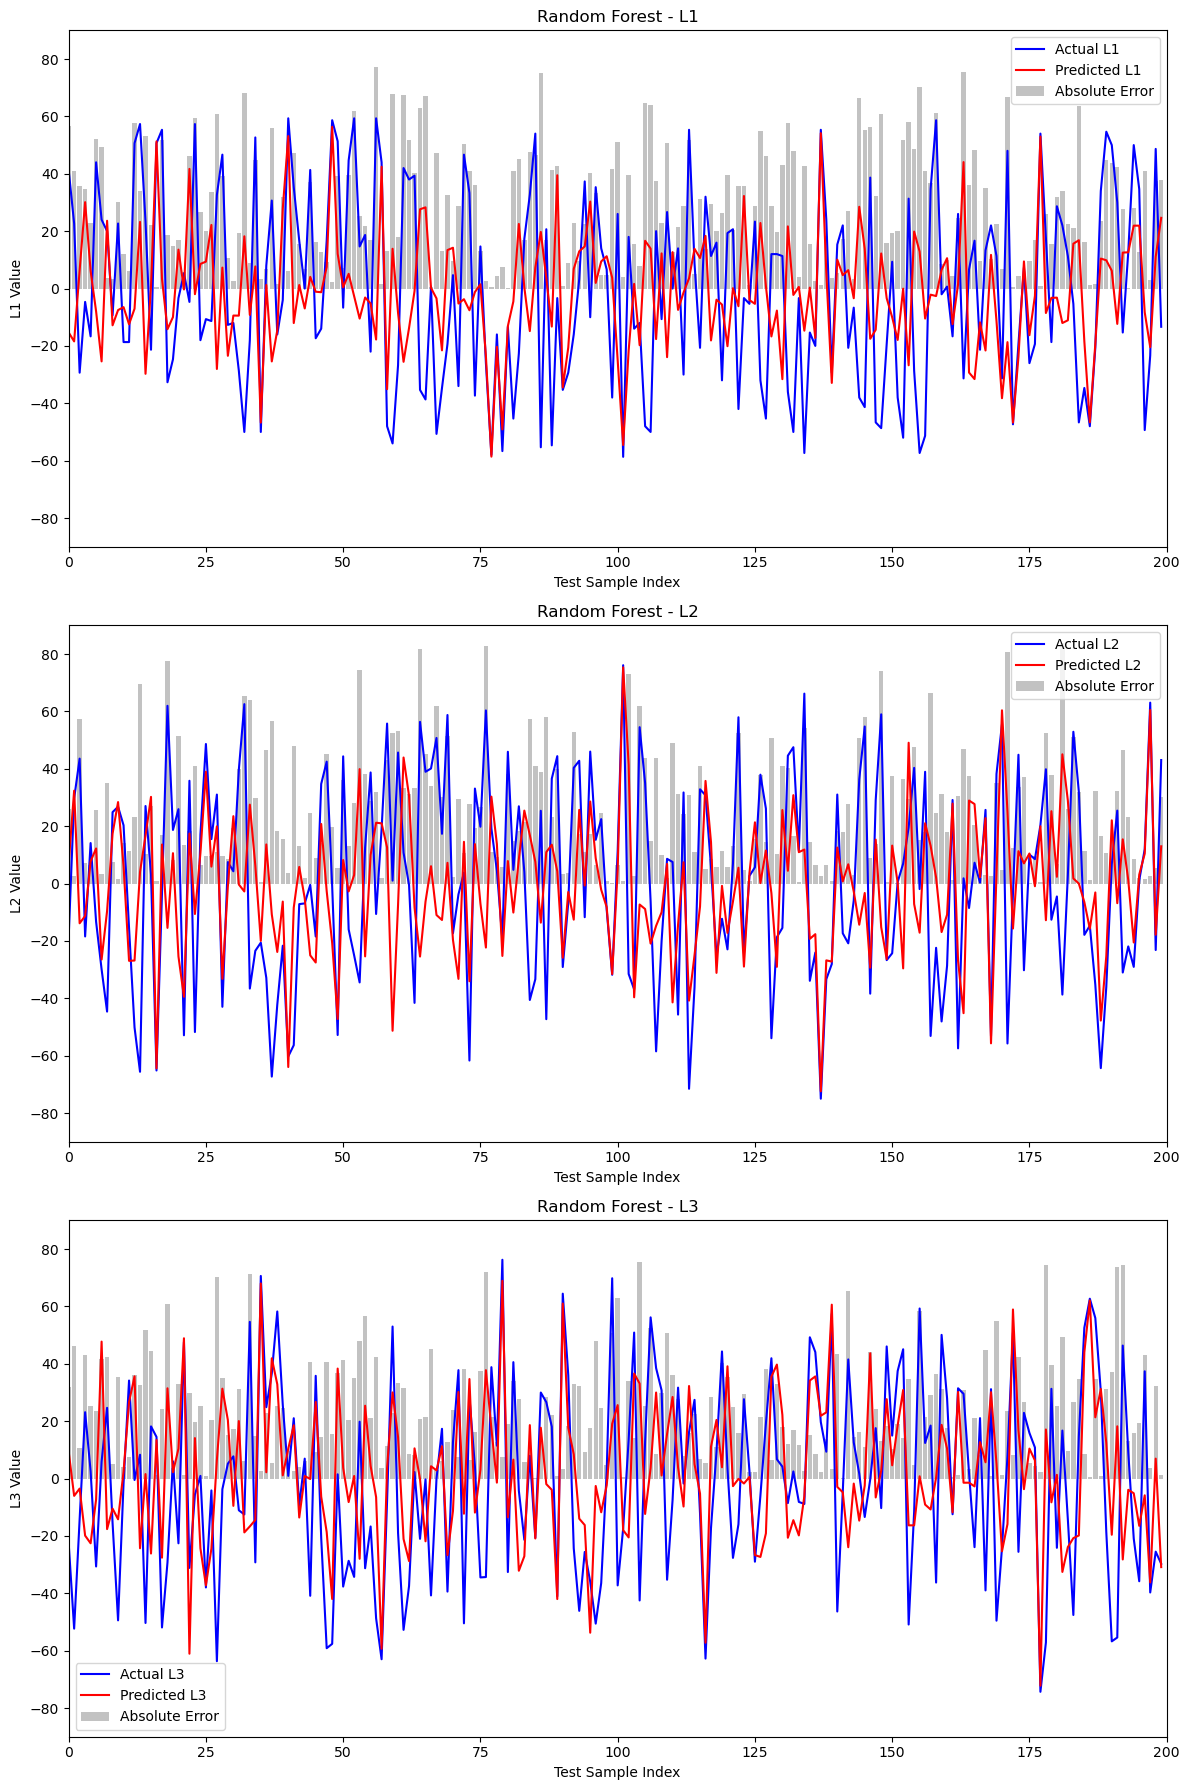

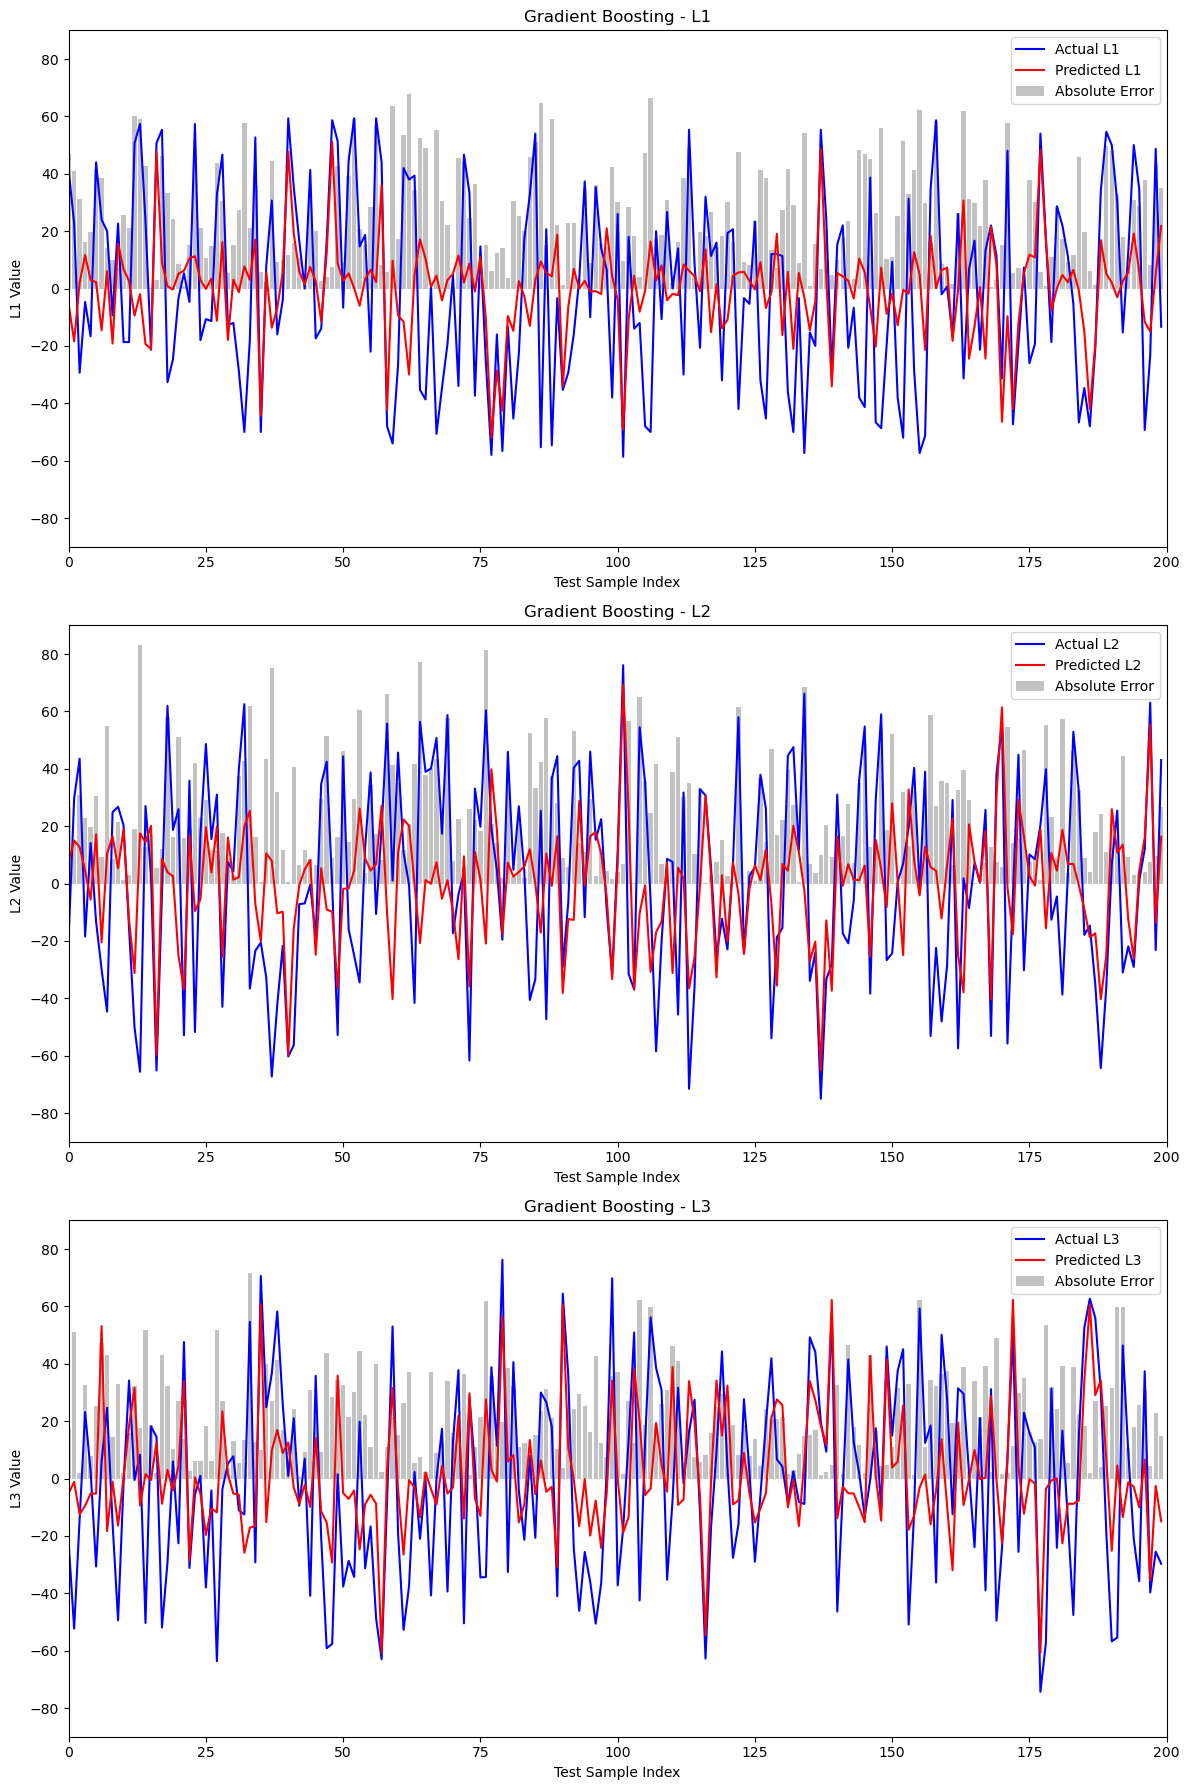

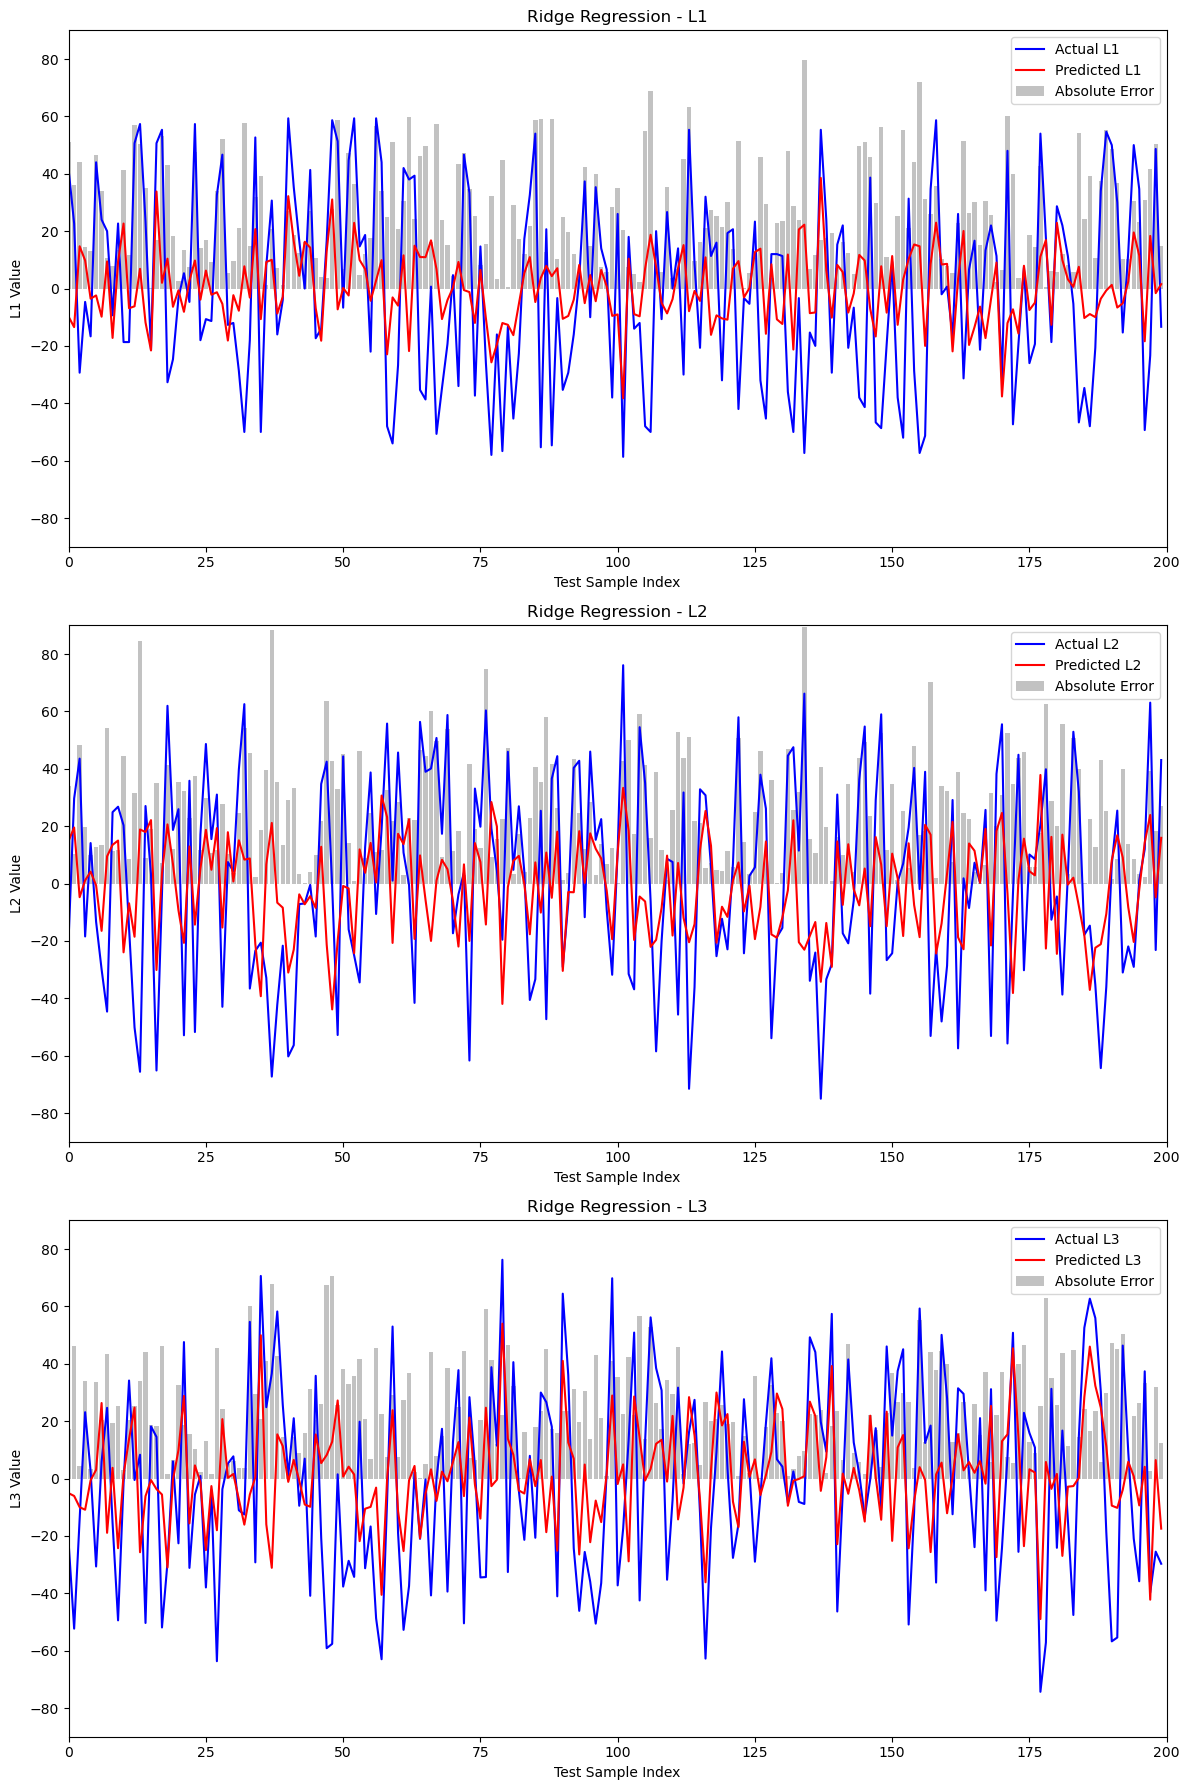

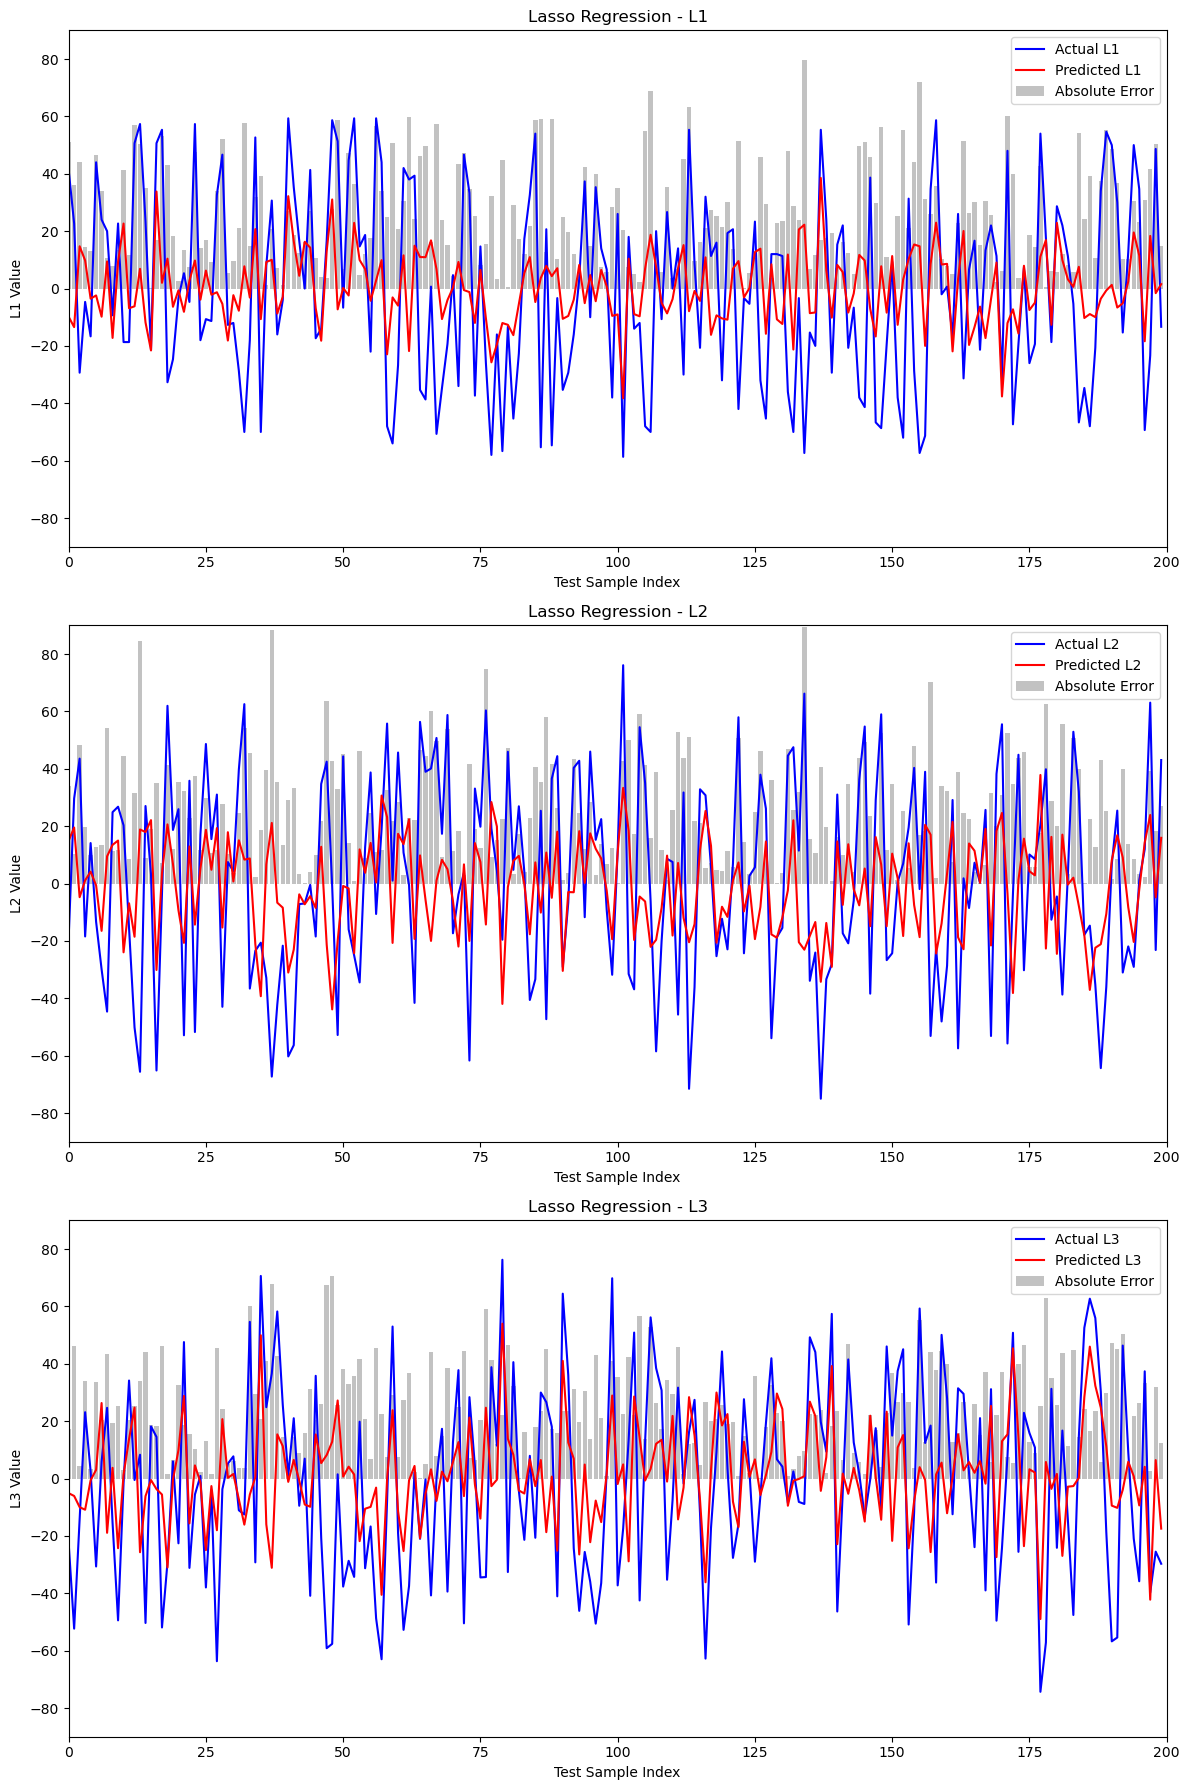

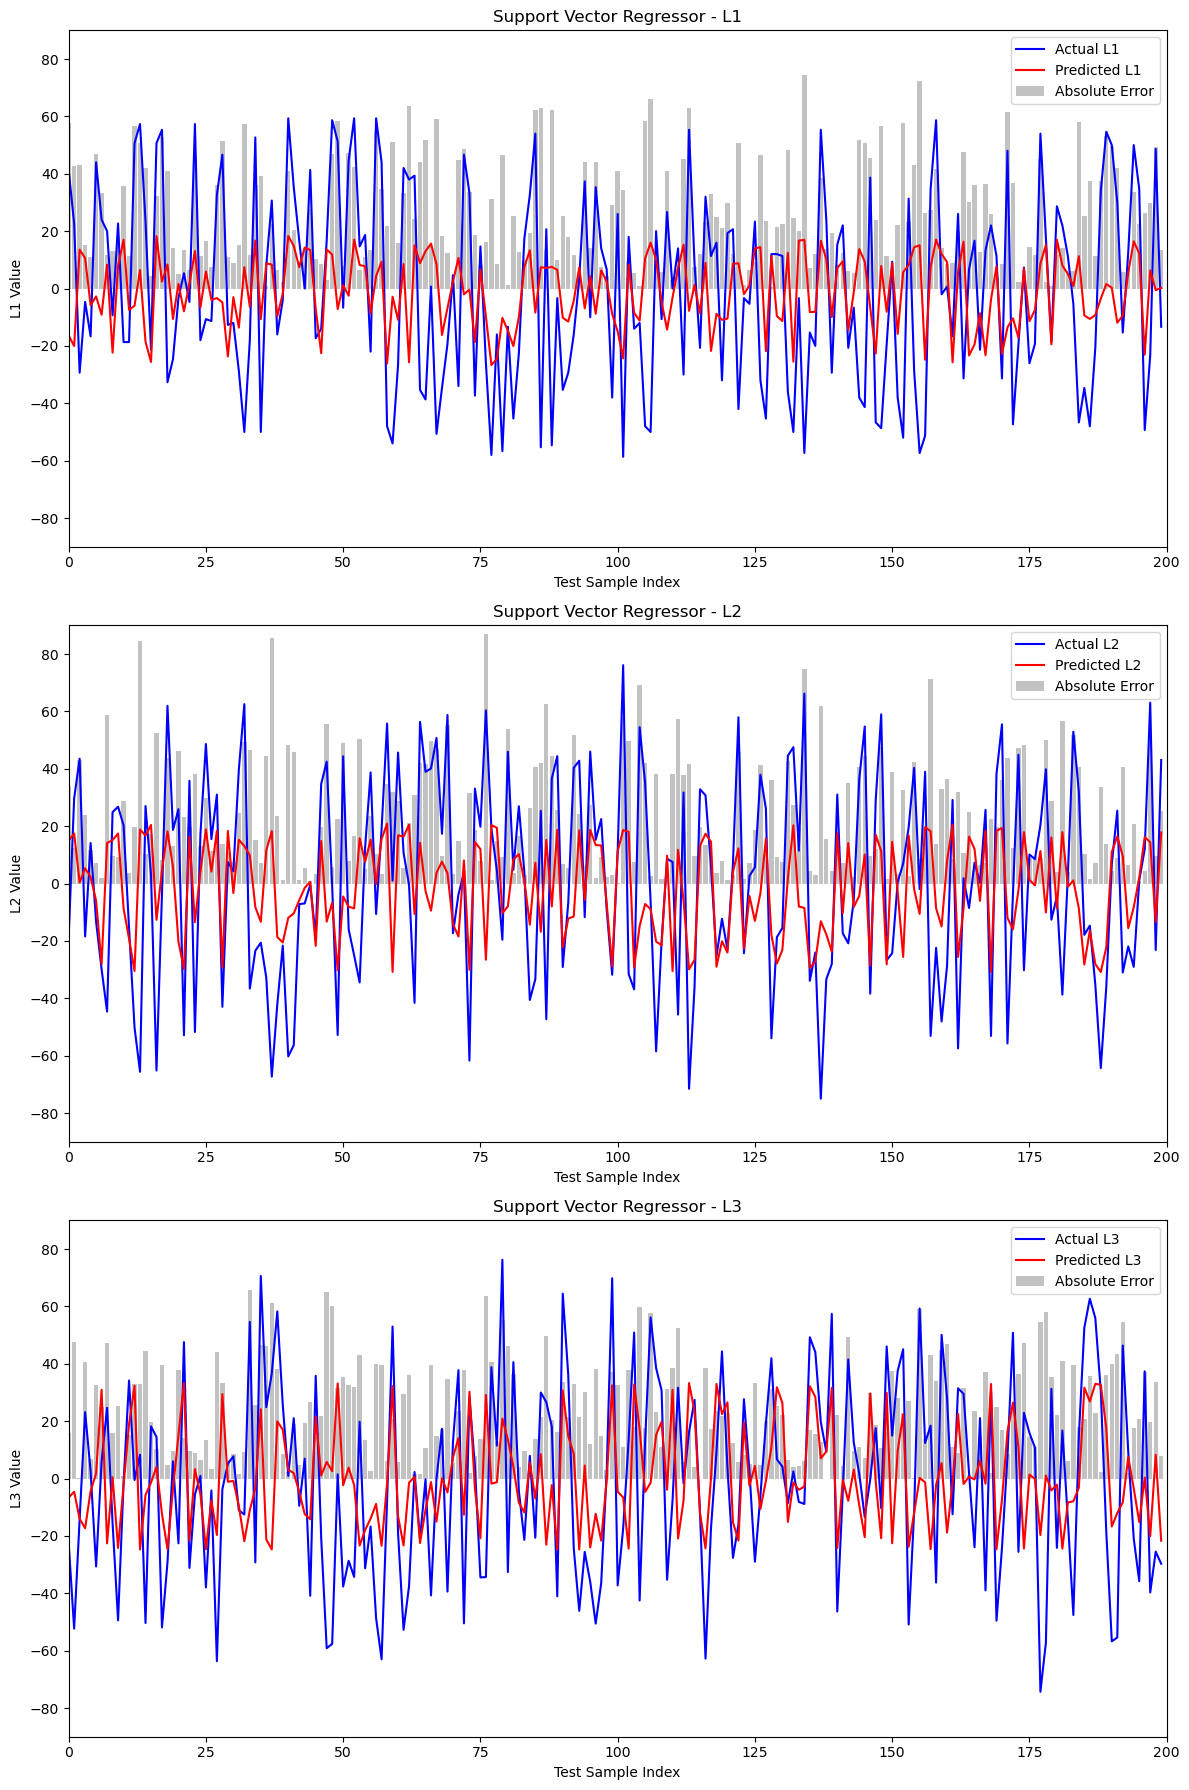

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.svm import SVR
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# Load the dataset
file_path = "D://_NYCU GIA//_Thesis//_gh//_data//training.csv"
data = pd.read_csv(file_path)

# Extract input and output columns
X = data[['α', 'β']]
y = data[['L1', 'L2', 'L3']]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize models
models = {
    "Random Forest": MultiOutputRegressor(RandomForestRegressor(n_estimators=100, random_state=42)),
    "Gradient Boosting": MultiOutputRegressor(GradientBoostingRegressor(n_estimators=100, random_state=42)),
    "Ridge Regression": MultiOutputRegressor(Ridge(alpha=1.0)),
    "Lasso Regression": MultiOutputRegressor(Lasso(alpha=0.1)),
    "Support Vector Regressor": MultiOutputRegressor(SVR())
}

results = []

# Train and evaluate each model
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    
    results.append({
        "Model": name,
        "Test MSE": mse,
        "Test MAE": mae
    })
    
    # Plot comparisons for each output
    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 18))
    for i, label in enumerate(['L1', 'L2', 'L3']):
        axes[i].plot(range(len(y_test)), y_test[label], color='blue', label=f'Actual {label}')
        axes[i].plot(range(len(y_pred)), y_pred[:, i], color='red', label=f'Predicted {label}')
        abs_diff = abs(y_test[label] - y_pred[:, i])
        axes[i].bar(range(len(y_test)), abs_diff, color='darkgrey', alpha=0.7, label='Absolute Error')
        axes[i].set_title(f'{name} - {label}')
        axes[i].set_xlabel('Test Sample Index')
        axes[i].set_ylabel(f'{label} Value')
        axes[i].legend()
        axes[i].set_xlim(0, 200)  # Set xlim here
        axes[i].set_ylim(-90, 90)  # Set ylim here
    fig.tight_layout()
#     plt.savefig(f"{name.replace(' ', '_')}_results.png")
#     plt.show()

# Display the results
results_df = pd.DataFrame(results)
print(results_df)

# Select the most fit model based on the lowest MSE
best_model_name = results_df.loc[results_df['Test MSE'].idxmin()]['Model']
best_model = models[best_model_name]
best_model.fit(X_train, y_train)
best_model_y_pred = best_model.predict(X_test)

def construct_linear_equation(label, intercept, coefs):
    terms = ['α', 'β']
    equation = f"{label} = {intercept:.4f}"
    for term, coef in zip(terms, coefs):
        equation += f" + ({coef:.4f})*{term}"
    return equation

def construct_polynomial_equation(label, intercept, coefs, terms):
    equation = f"{label} = {intercept:.4f}"
    for term, coef in zip(terms, coefs):
        equation += f" + ({coef:.4f})*{term}"
    return equation

# Determine the transfer functions
if "Ridge" in best_model_name or "Lasso" in best_model_name:
    # Linear regression for transfer functions
    intercepts = [estimator.intercept_ for estimator in best_model.estimators_]
    coefs = [estimator.coef_ for estimator in best_model.estimators_]
    
    transfer_functions = []
    for i, label in enumerate(['L1', 'L2', 'L3']):
        transfer_functions.append(construct_linear_equation(label, intercepts[i], coefs[i]))
else:
    # Polynomial regression for transfer functions
    poly = PolynomialFeatures(degree=2, include_bias=False)
    X_poly = poly.fit_transform(X_train)
    
    poly_model_L1 = LinearRegression().fit(X_poly, y_train['L1'])
    poly_model_L2 = LinearRegression().fit(X_poly, y_train['L2'])
    poly_model_L3 = LinearRegression().fit(X_poly, y_train['L3'])
    
    coefs_L1 = poly_model_L1.coef_
    coefs_L2 = poly_model_L2.coef_
    coefs_L3 = poly_model_L3.coef_
    intercept_L1 = poly_model_L1.intercept_
    intercept_L2 = poly_model_L2.intercept_
    intercept_L3 = poly_model_L3.intercept_
    
    terms = poly.get_feature_names_out(['α', 'β'])
    
    transfer_functions = [
        construct_polynomial_equation('L1', intercept_L1, coefs_L1, terms),
        construct_polynomial_equation('L2', intercept_L2, coefs_L2, terms),
        construct_polynomial_equation('L3', intercept_L3, coefs_L3, terms)
    ]

print("Best Model:", best_model_name)
print("Transfer Functions:")
for func in transfer_functions:
    print(func)


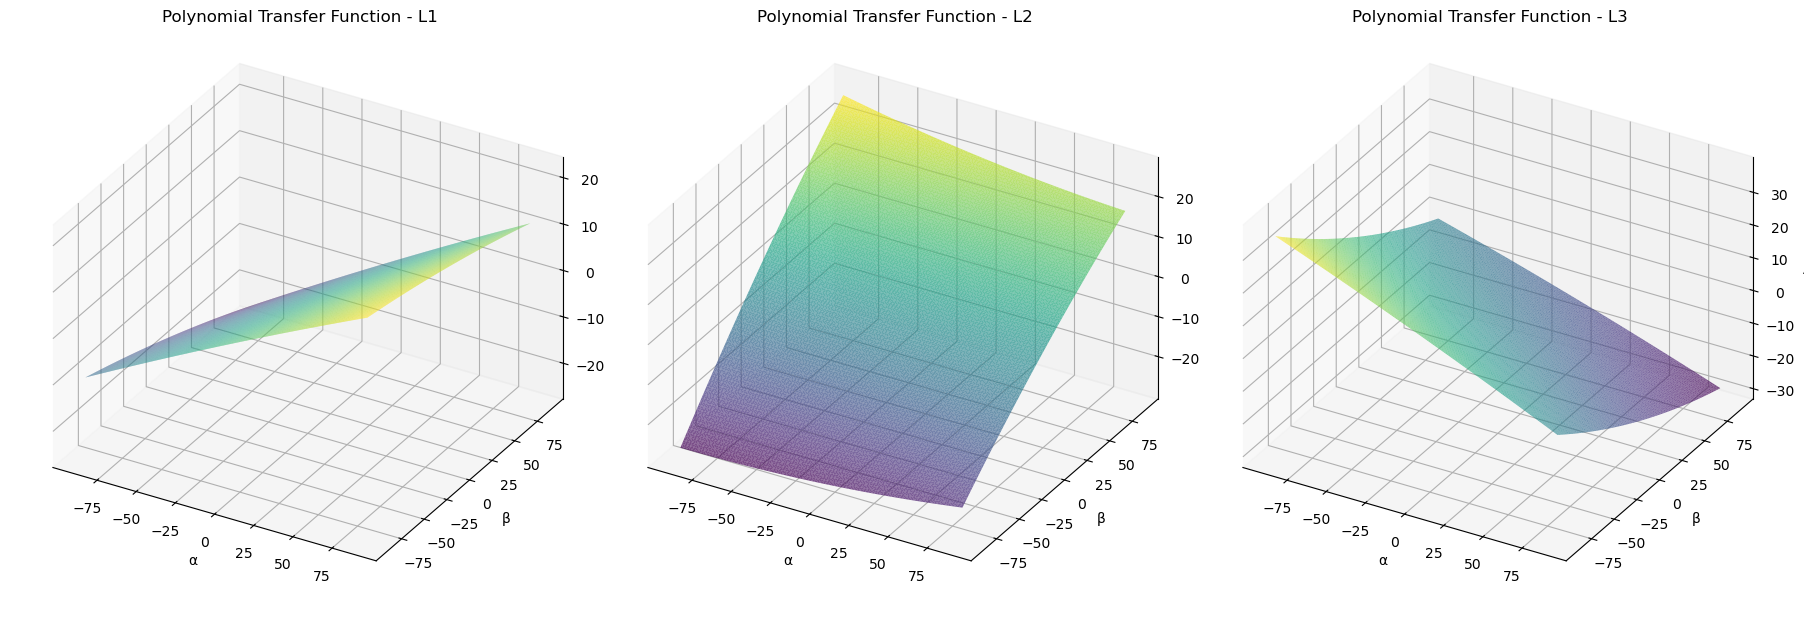

In [9]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd

# Plot the polynomial transfer functions as 3D surface plots
fig = plt.figure(figsize=(18,6.5))
for i, (label, model) in enumerate(zip(['L1', 'L2', 'L3'], [poly_model_L1, poly_model_L2, poly_model_L3])):
    ax = fig.add_subplot(1, 3, i+1, projection='3d', proj_type='ortho')

    # Generate a range of input values
    alpha_range = np.linspace(-90, 90, 100)
    beta_range = np.linspace(-90, 90, 100)
    alpha_grid, beta_grid = np.meshgrid(alpha_range, beta_range)
    X_grid = pd.DataFrame(np.c_[alpha_grid.ravel(), beta_grid.ravel()], columns=['α', 'β'])
    X_grid_poly = poly.transform(X_grid)

    # Predict the output values
    y_grid_pred = model.predict(X_grid_poly)

    # Plot the transfer function as a 3D trisurf plot
    ax.plot_trisurf(X_grid['α'], X_grid['β'], y_grid_pred, cmap='viridis', edgecolor='none', alpha=0.7)
    ax.set_title(f'Polynomial Transfer Function - {label}')
    ax.set_xlabel('α')
    ax.set_ylabel('β')
    ax.set_zlabel('ΔL')
    
plt.tight_layout()
# plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05, hspace=0.5)
plt.savefig("fig_Polynomial_Transfer_Functions_3D.png", dpi=300)
plt.show()

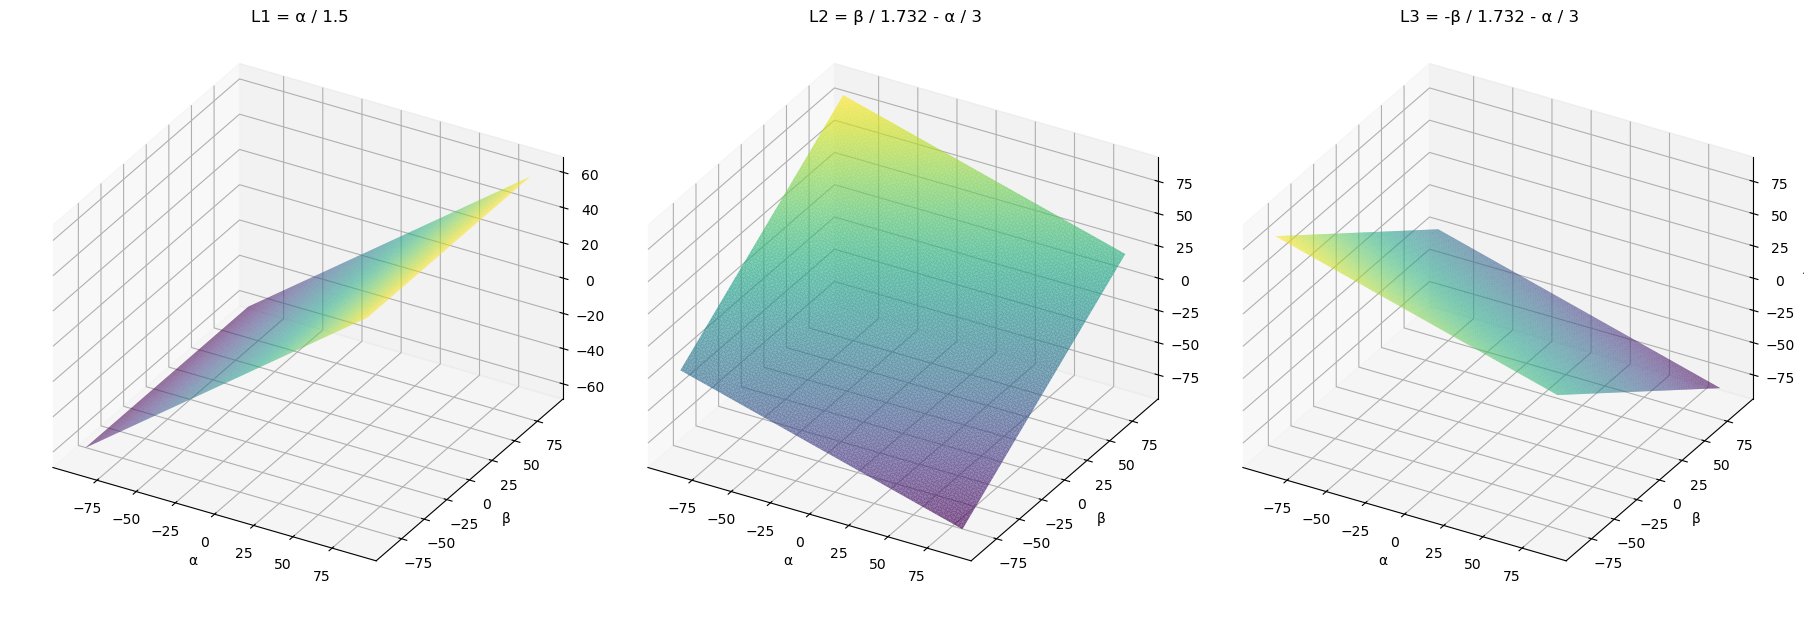

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Define the equations
def L1(alpha):
    return alpha / 1.5

def L2(alpha, beta):
    return beta / 1.732 - alpha / 3

def L3(alpha, beta):
    return -beta / 1.732 - alpha / 3

# Generate a range of input values
alpha_range = np.linspace(-90, 90, 100)
beta_range = np.linspace(-90, 90, 100)
alpha_grid, beta_grid = np.meshgrid(alpha_range, beta_range)
alpha_flat = alpha_grid.ravel()
beta_flat = beta_grid.ravel()

# Calculate the output values
L1_values = L1(alpha_flat)
L2_values = L2(alpha_flat, beta_flat)
L3_values = L3(alpha_flat, beta_flat)

# Plot the transfer functions as 3D trisurf plots
fig = plt.figure(figsize=(18, 6.5))

# Plot L1
ax1 = fig.add_subplot(1, 3, 1, projection='3d', proj_type='ortho')
ax1.plot_trisurf(alpha_flat, beta_flat, L1_values, cmap='viridis', edgecolor='none', alpha=0.7)
ax1.set_title('L1 = α / 1.5')
ax1.set_xlabel('α')
ax1.set_ylabel('β')
ax1.set_zlabel('ΔL')

# Plot L2
ax2 = fig.add_subplot(1, 3, 2, projection='3d', proj_type='ortho')
ax2.plot_trisurf(alpha_flat, beta_flat, L2_values, cmap='viridis', edgecolor='none', alpha=0.7)
ax2.set_title('L2 = β / 1.732 - α / 3')
ax2.set_xlabel('α')
ax2.set_ylabel('β')
ax2.set_zlabel('ΔL')

# Plot L3
ax3 = fig.add_subplot(1, 3, 3, projection='3d', proj_type='ortho')
ax3.plot_trisurf(alpha_flat, beta_flat, L3_values, cmap='viridis', edgecolor='none', alpha=0.7)
ax3.set_title('L3 = -β / 1.732 - α / 3')
ax3.set_xlabel('α')
ax3.set_ylabel('β')
ax3.set_zlabel('ΔL')

plt.tight_layout()
plt.savefig("fig_Original_Transfer_Functions_3D.png", dpi=300)
plt.show()
